# Notebook to train and test standard ML models on the data

### Begin by setting up the data and defining the models

In [53]:
# Imports general
import pdb
import importlib
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
from scipy import interp
import matplotlib.pyplot as plt
%matplotlib inline
import make_aucs

# Imports scikit-learn
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn import tree
from sklearn import svm
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

In [6]:
# Load data
data_file = '/Users/htomlinson/Documents/Rhodes/RAIL/UMD Sleep Apnea data.csv'
data = pd.read_csv(data_file)

# Define variables
admission_variables = ['gender', 'ethnicity', 'term', 'bmi', 'age', 'allergies', 'asthma', 'gerd', 'tonsilsize']
laboratory_variables = ['nrem', 'rem', 'sleepefficiency', 'arousali', \
                        'tst50co2', 'zscore', 'oahi', 'cai', 'oai', \
                        'ohi', 'lowsao2', 'peakc02', 'tb90']
test_variable = ['ahi']
categorical_variables = ["gender", "ethnicity", "allergies", "asthma", "gerd"]
continuous_variables = ["bmi", "age","tonsilsize"]

# Set AHI threshold
ahi_thresh = 5

# Remove NAs from data
data["term"].fillna(0, inplace=True)

# Encode categorical data
for cat_label in categorical_variables:
    temp = pd.get_dummies(data[cat_label], drop_first=True)
    name_dict = {old_name:cat_label + "_" + str(old_name) for old_name in temp.columns}
    temp.rename(columns=name_dict,inplace=True)
    data = pd.concat((data, temp),axis=1)

# Set up x and y matrices
final_vars = list(set(data.columns) - set(categorical_variables) - set(laboratory_variables) - set(test_variable))
x_data = data[final_vars]
y_data = pd.Series(data['ahi']>ahi_thresh, index=data.index)

# Create test set and reset dataframe indices
xtest = x_data.loc[300:].reset_index(drop=True)
ytest = y_data.loc[300:].reset_index(drop=True)
xtrain = x_data.loc[:299].reset_index(drop=True)
ytrain = y_data.loc[:299].reset_index(drop=True)

In [7]:
# Initialise models
models = {\
'Logistic Regression l2 reg':LogisticRegression(penalty = 'l2'), \
'Logistic Regression l1 reg':LogisticRegression(penalty = 'l1'), \
'Logistic Regression': LogisticRegression(), \
'Decision Trees': tree.DecisionTreeClassifier(criterion='gini'), \
'SVM': svm.SVC(probability=True), \
'Random Forest': RandomForestClassifier(), \
'SVM linear': svm.SVC(probability=True, kernel='linear'), \
'SVM reg': svm.SVC(probability=True), \
'SVM linear reg': svm.SVC(probability=True, kernel='linear')}

### First try models without feature engineering

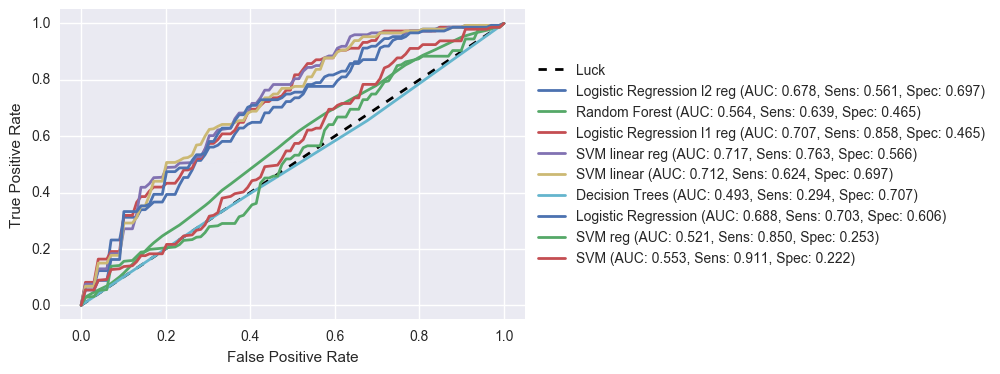

In [8]:
make_aucs.main(data = [xtrain, ytrain], models=models, kfolds=5)

### Try normalise the data

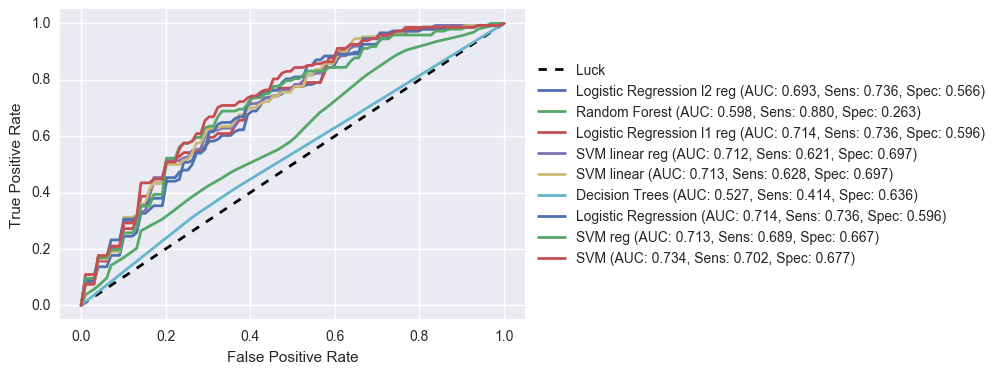

In [9]:
# Normalise continuous data
xtrain_norm = xtrain.copy()
scaler = preprocessing.StandardScaler().fit(xtrain_norm)
xtrain_norm[continuous_variables] = \
pd.DataFrame(scaler.transform(xtrain_norm), columns=xtrain_norm.columns,index=xtrain_norm.index)[continuous_variables]

make_aucs.main(data = [xtrain_norm, ytrain], models=models, kfolds=5)

### Try model with PCA based feature reduction

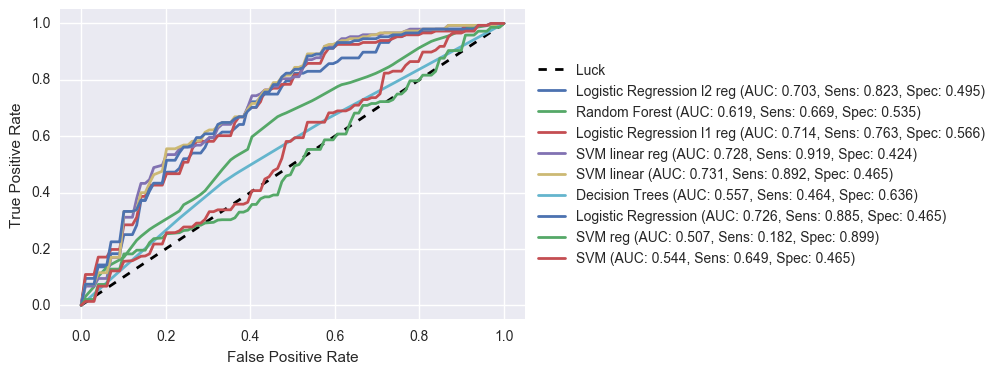

In [10]:
# Use PCA to remove feature vectors
xtrain_pca = xtrain.copy()
pca = PCA(n_components=6)
pca.fit(xtrain_pca)
xtrain_pca = pd.DataFrame(pca.transform(xtrain_pca),index=xtrain_pca.index)

# Try lower dimensional feature set on training data
make_aucs.main(data = [xtrain_pca, ytrain], models=models, kfolds=5)

### Try model with normalised data and PCA based feature reduction

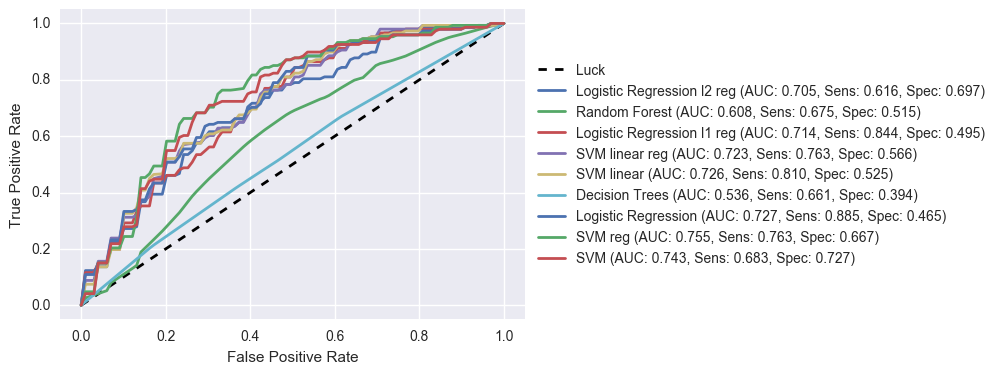

In [11]:
# Use PCA to remove feature vectors
xtrain_pca_norm = xtrain_norm.copy()
pca = PCA(n_components=6)
pca.fit(xtrain_pca_norm)
xtrain_pca_norm = pd.DataFrame(pca.transform(xtrain_pca_norm),index=xtrain_pca_norm.index)

# Try lower dimensional feature set on training data
make_aucs.main(data = [xtrain_pca_norm, ytrain], models=models, kfolds=5)

### Try model with polynomial features and normalisation

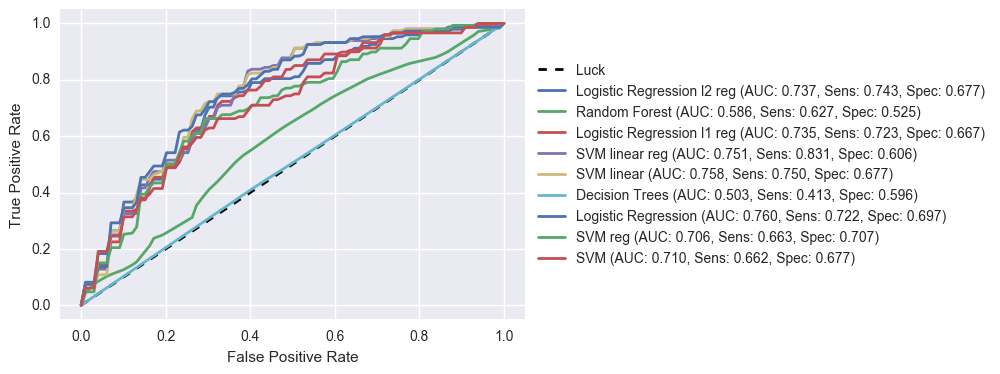

In [12]:
# Use polynomial features to encode higher degree interactions but only for continuous
xtrain_poly = xtrain_norm.copy()
xtrain_poly_temp = xtrain_norm.copy()
poly = preprocessing.PolynomialFeatures(degree=2)
poly.fit(xtrain_poly[continuous_variables])
cols_without_cont = list(set(xtrain_poly.columns) - set(continuous_variables))
xtrain_poly = pd.DataFrame(poly.transform(xtrain_poly[continuous_variables]),index=xtrain_poly.index)
xtrain_poly[cols_without_cont] = xtrain_poly_temp[cols_without_cont]

# Try lower dimensional feature set on training data
make_aucs.main(data = [xtrain_poly, ytrain], models=models, kfolds=5)

### Try model with polynomial features, normalisation and PCA feature reduction on continuous variables

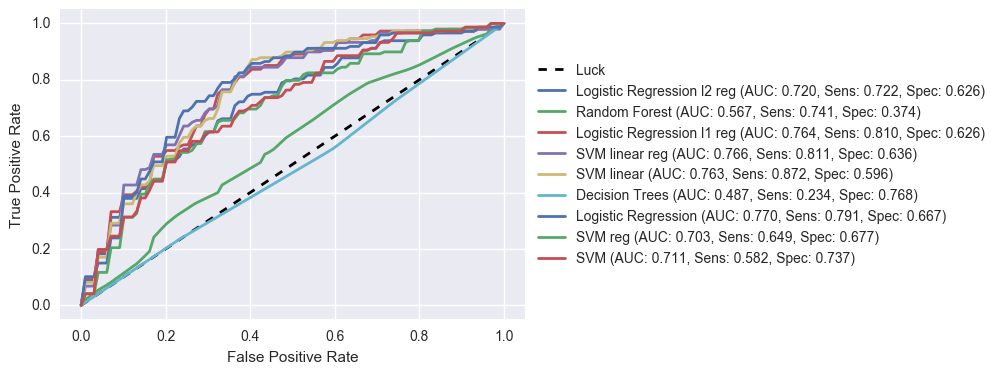

In [38]:
# Use polynomial features to encode higher degree interactions but only for continuous
xtrain_poly_pca_cont_norm = xtrain_norm.copy()
xtrain_poly_cont_temp = xtrain_norm.copy()
poly = preprocessing.PolynomialFeatures(degree=2)
poly.fit(xtrain_poly_pca_cont_norm[continuous_variables])
cols_without_cont = list(set(xtrain_poly_cont_temp.columns) - set(continuous_variables))
xtrain_poly_pca_cont_norm = pd.DataFrame(poly.transform(xtrain_poly_pca_cont_norm[continuous_variables]), \
                           index=xtrain_poly_pca_cont_norm.index)

pca = PCA(n_components=7)
pca.fit(xtrain_poly_pca_cont_norm)
xtrain_poly_pca_cont_norm = pd.DataFrame(pca.transform(xtrain_poly_pca_cont_norm),index=xtrain_poly_pca_cont_norm.index)

xtrain_poly_pca_cont_norm[cols_without_cont] = xtrain_poly_cont_temp[cols_without_cont]

# # Try lower dimensional feature set on training data
make_aucs.main(data = [xtrain_poly_pca_cont_norm, ytrain], models=models, kfolds=5)

### Try model with polynomial features, normalisation and PCA feature reduction on all variables

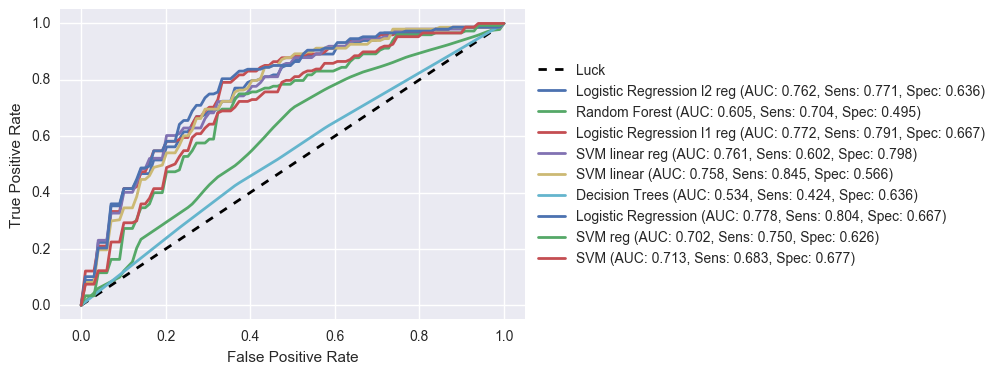

In [40]:
# Use PCA to remove feature vectors
xtrain_poly_pca_norm = xtrain_poly.copy()
pca = PCA(n_components=10)
pca.fit(xtrain_poly_pca_norm)
xtrain_poly_pca_norm = pd.DataFrame(pca.transform(xtrain_poly_pca_norm),index=xtrain_poly_pca_norm.index)

# Try lower dimensional feature set on training data
make_aucs.main(data = [xtrain_poly_pca_norm, ytrain], models=models, kfolds=5)

### Try Naive Bayes on columns chosen by Farah

AUROC score: 0.707 (+/- 0.125)


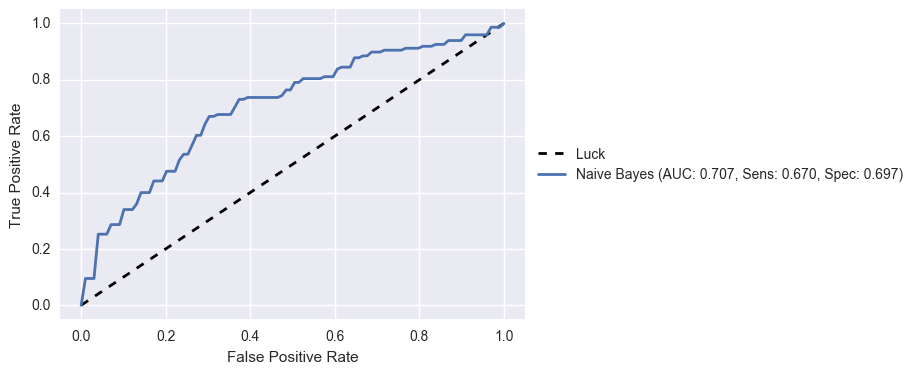

In [64]:
# Sort data into columns
NB_cols = ['bmi','tonsilsize', 'term','gender_Male']
xtrain_NB = xtrain.copy()
xtrain_NB = xtrain_NB[NB_cols]
model_NB = {'Naive Bayes': GaussianNB()}

# Test
make_aucs.main(data = [xtrain_NB, ytrain], models=model_NB, kfolds=5)

# Check against built-in cross_val_score
auroc_scores = cross_val_score(GaussianNB(), xtrain_NB, ytrain, cv=5, scoring ='roc_auc')
print("AUROC score: {:0.3f} (+/- {:0.3f})".format(auroc_scores.mean(), auroc_scores.std() * 2))